In [1]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install bta-lib


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:

pip install empyrial

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import btalib
from empyrial import empyrial, Engine
import plotly.express as px
import datetime
%matplotlib inline

In [6]:
tickers = ["GOOG", "MSFT", "NFLX", "AAPL", "FB"]

In [7]:
## Reading the stock data from Yfinance for our stocks ["GOOG", "MSFT", "NFLX", "AAPL", "FB"]

def hist_performance(tickers, interval, period, auto_adjust = True):
    historical_data_object = []
    close_hist = pd.DataFrame()
    indicator_hist = pd.DataFrame()
    returns = pd.DataFrame()
    expected_returns_avg = pd.DataFrame()

    
    [historical_data_object.append(yf.Ticker(f"{ticker}")) for ticker in tickers]
    
    for obj in historical_data_object:
        symbol = obj.info['symbol']
        hist = obj.history(period = period, auto_adjust = auto_adjust, interval = interval).dropna()
        close_hist[symbol] = hist.Close
        indicator_hist[symbol] = btalib.mfi(hist.High, hist.Low, hist.Close, hist.Volume).df.mfi

        obj_return = hist.Close.pct_change().dropna()
        returns[symbol] = obj_return
        
    expected_returns_avg[0] = returns.mean(axis=0)
    indicator_hist = indicator_hist.dropna()
    
    return historical_data_object, close_hist, returns, expected_returns_avg, indicator_hist

historical_data_object, close_hist, returns, expected_returns_avg, indicator_hist = hist_performance(tickers, "1d", "5y")
print(indicator_hist)
print('historical_data_object is', historical_data_object)
print('indicator_hist is', indicator_hist)
print("close_hist is:", close_hist)
print("returns is:", returns)
print("expected_returns_avg is:", expected_returns_avg)

                 GOOG       MSFT       NFLX       AAPL         FB
Date                                                             
2016-11-18  25.907139  38.891383  23.448971  38.139073  23.910882
2016-11-21  31.261605  43.675063  30.077382  44.957199  30.404675
2016-11-22  36.891170  48.716102  35.950184  50.284189  36.799308
2016-11-23  37.474517  48.624981  36.187622  50.217775  40.850237
2016-11-25  41.612883  50.806100  37.448860  54.479413  42.998739
...               ...        ...        ...        ...        ...
2021-10-25  54.656612  63.009504  61.603272  50.887131  48.345174
2021-10-26  56.105977  63.256067  60.731221  58.634492  43.229515
2021-10-27  61.058731  67.331560  56.397376  52.257473  35.032849
2021-10-28  62.816790  73.531919  61.235453  60.514439  44.821504
2021-10-29  69.120344  80.258976  66.233438  56.756228  51.412599

[1245 rows x 5 columns]
historical_data_object is [yfinance.Ticker object <GOOG>, yfinance.Ticker object <MSFT>, yfinance.Ticker object <NFLX

In [8]:
print(close_hist)

                   GOOG        MSFT        NFLX        AAPL          FB
Date                                                                   
2016-10-31   784.539978   55.439709  124.870003   26.620605  130.990005
2016-11-01   783.609985   55.328674  123.300003   26.139961  129.500000
2016-11-02   768.700012   54.986347  122.339996   26.163403  127.169998
2016-11-03   762.130005   54.782803  122.139999   25.882965  120.000000
2016-11-04   762.020020   54.320190  122.029999   25.649660  120.750000
...                 ...         ...         ...         ...         ...
2021-10-25  2775.459961  308.130005  671.659973  148.639999  328.690002
2021-10-26  2793.439941  310.109985  668.520020  149.320007  315.809998
2021-10-27  2928.550049  323.170013  662.919983  148.850006  312.220001
2021-10-28  2922.580078  324.350006  674.049988  152.570007  316.920013
2021-10-29  2965.409912  331.619995  690.309998  149.800003  323.570007

[1259 rows x 5 columns]


In [12]:
# Equal Weighted Portfolio- Calculation:

numstocks = len(tickers)
equal_weights = np.repeat(1/numstocks, numstocks)
equal_weight_return_daily = []
avg_return = expected_returns_avg.loc[tickers, :][0]
annualized = ((1+avg_return)**252)-1
annualized_weighted = equal_weights * annualized
cumulative_annualized_weighted = np.sum(annualized_weighted)

print("The expected annual return for Equal weighted portfolio is:",  round(cumulative_annualized_weighted*100,3), '%')

The expected annual return for Equal weighted portfolio is: 41.972 %


In [13]:
# Market Weighted Portfolio- Calculation:

1. 
# Finding Market Capitilization for each portfolio:

mcaps = [obj.info['marketCap'] for obj in historical_data_object 
    if obj.info['symbol'] in tickers] 

print(f"The Capitilization for each portfolio is:", mcaps)

#----------------------------------------

2.
# Calculate the market cap weight for each holding:

market_cap_weights = np.array([mcap / np.sum(mcaps) 
    for mcap in mcaps])

print(f"The market cap weight for each holding is:", market_cap_weights)

#----------------------------------------

3. 
# Calculate the Expected Annual return for the Market Capital Portfolio:

mcap_portfolio_annual_return = annualized.mul(market_cap_weights).sum()
#print(f"The expected annual return of the market cap weighted portfolio is {round(mcap_portfolio_annual_return,3)*100}%.")
print("The expected annual return of the market cap weighted portfolio is:",  round(mcap_portfolio_annual_return,3)*100, '%')

The Capitilization for each portfolio is: [1966366261248, 2489796263936, 305774198784, 2476224020480, 900094099456]
The market cap weight for each holding is: [0.24162014 0.30593737 0.03757245 0.30426966 0.11060038]
The expected annual return of the market cap weighted portfolio is: 42.9 %


In [ ]:
## Calculating Standard Deviation & Co-Variance Matrix to calculate Portfolio Volatility (σ):

std_dev_daily = []
for i in returns[tickers]:
    std_dev_daily.append(np.std(returns[i].dropna()))
std_dev_annual = np.array(std_dev_daily) * (len(returns[tickers])**0.5)
print(std_dev_annual)

cov_daily = returns[tickers].cov()
cov_annualized = cov_daily * len(returns[tickers])
print(cov_annualized)

In [ ]:
## Portfolio Volatility for Equal Weighted Portfolio:

equal_portfolio_std = np.sqrt(np.dot(equal_weights.T, np.dot(cov_annualized, equal_weights)))
print("The equal weighted portfolio annual volatility is", round(equal_portfolio_std,3)*100,"%")


## Portfolio Volatility for Market Cap Weighted Portfolio:

mcap_portfolio_std = np.sqrt(np.dot(market_cap_weights.T, np.dot(cov_annualized, market_cap_weights)))
print("The market cap weighted portfolio annual volatility is", round(mcap_portfolio_std,3)*100, "%")


In [ ]:
## Calculating Sharpe ratios for Equal Weighted Portfolio

equal_portfolio_sharpe = (cumulative_annualized_weighted - 0) / equal_portfolio_std
print("The Sharpe Ratio for Equal Weighted Portfolio is", equal_portfolio_sharpe)



## Calculating Sharpe ratios for Market Cap Weighted Portfolio

mcap_portfolio_sharpe = (mcap_portfolio_annual_return - 0) / mcap_portfolio_std
print("The Sharpe Ratio for Market Cap Weighted  is", mcap_portfolio_sharpe)

sharpe_ratios = []
sharpe_ratios.append(float(equal_portfolio_sharpe))
sharpe_ratios.append(float(mcap_portfolio_sharpe))

In [ ]:
#####################################################################
####            Using Empyrial for Portfolio Allocation          ####
#####################################################################


In [14]:
sharpe_ratios = []
print(sharpe_ratios)

[]


Start date: 2012-10-01
End date: 2021-10-30


Backtest
                             
Annual return          42.06%
Cumulative return    2283.05%
Annual volatility     25.25 %
Winning day ratio      55.93%
Sharpe ratio             1.52
Calmar ratio              1.5
Information ratio        0.01
Stability                0.99
Max Drawdown         -27.85 %
Sortino ratio            2.28
Skew                     0.02
Kurtosis                  7.2
Tail Ratio               0.98
Common sense ratio       1.29
Daily value at risk    -2.0 %
Alpha                    0.22
Beta                     1.15

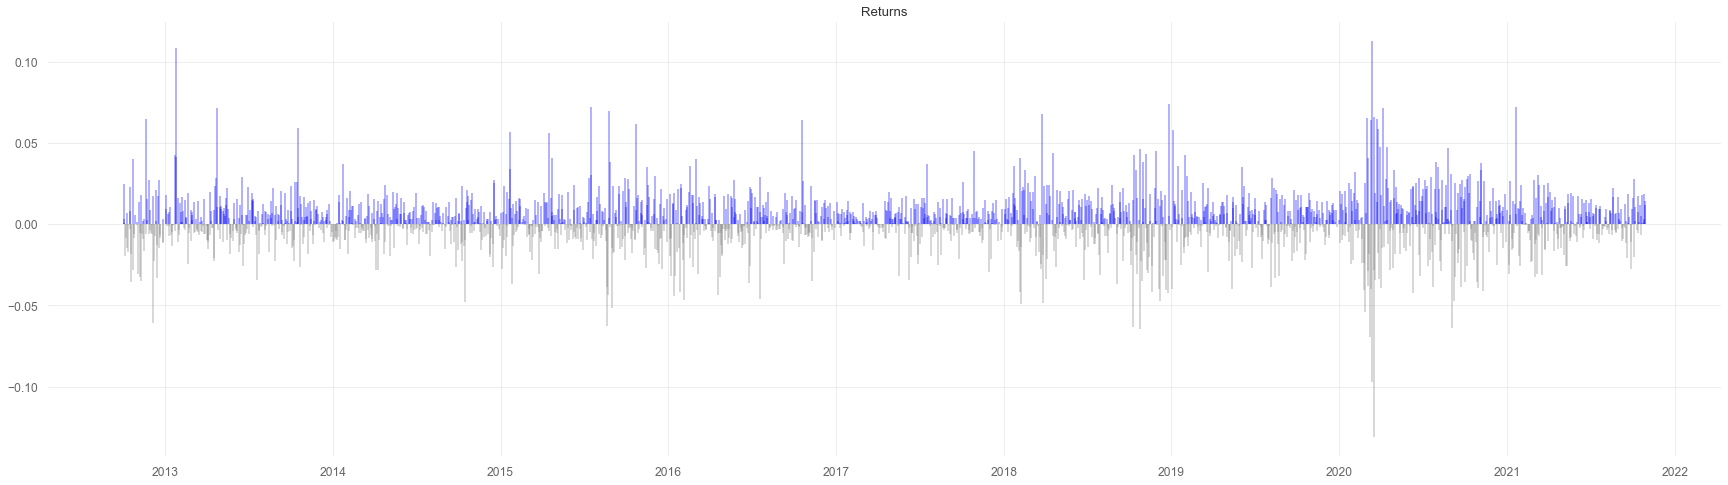

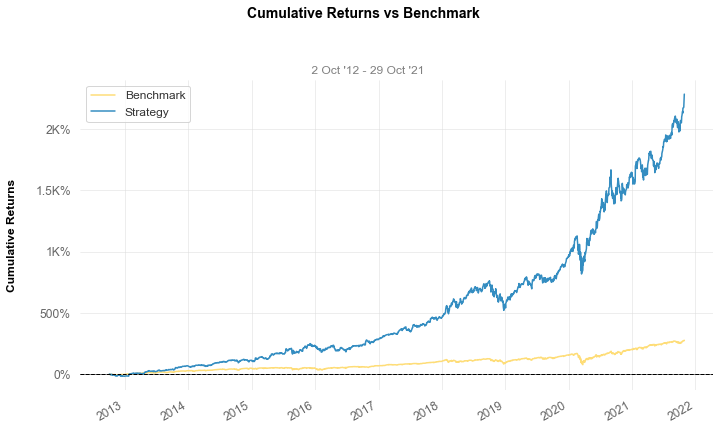

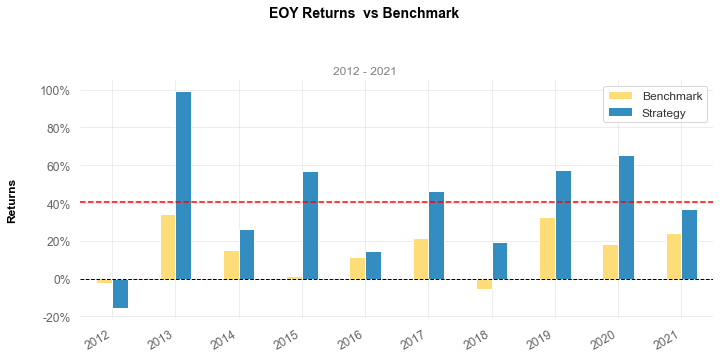

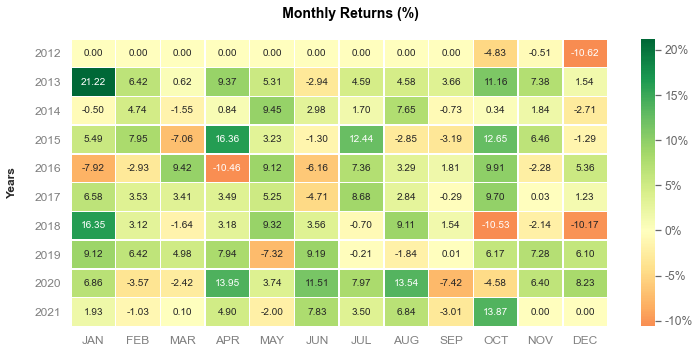

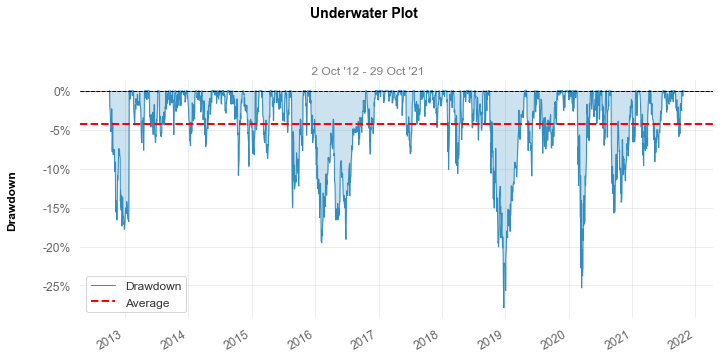

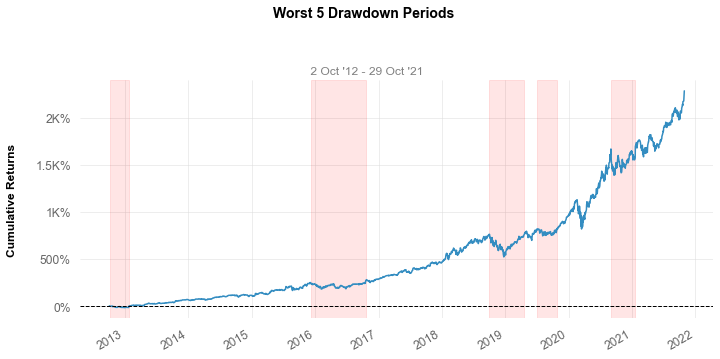

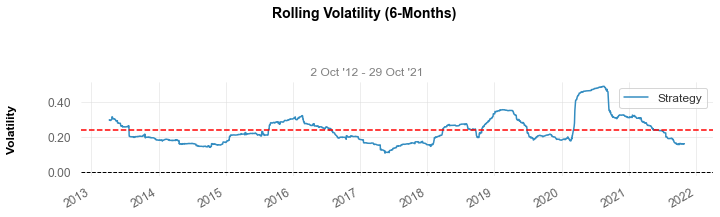

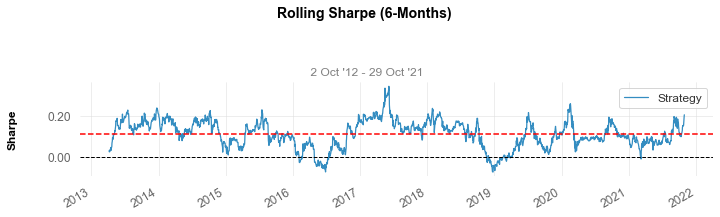

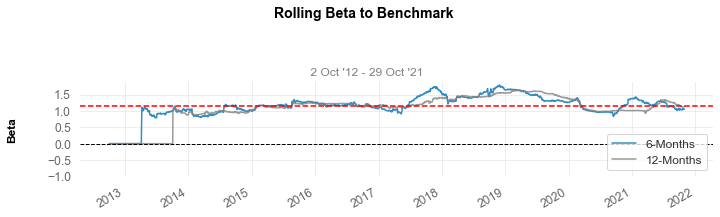

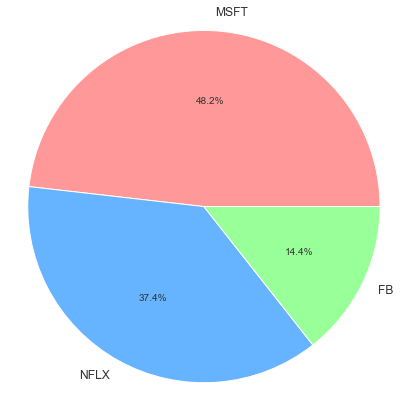

Sharpe_Ratio is : ['1.52']


In [15]:
## Global Efficient Frontier AKA MSR = Maximum Sharpe Method

portfolio_EF = Engine(
    start_date = "2012-10-01",
    portfolio = ["GOOG", "MSFT", "NFLX", "AAPL", "FB"],
    optimizer = "EF",
    rebalance = "1y",
)

portfolio_EF.weights

## The Portfolio's Performance:

empyrial(portfolio_EF)
sharpe_ratios.append(empyrial.SR)
print("Sharpe_Ratio is :", sharpe_ratios)

Start date: 2012-10-01
End date: 2021-10-30


Backtest
                             
Annual return          32.74%
Cumulative return     1190.7%
Annual volatility     22.55 %
Winning day ratio      56.81%
Sharpe ratio             1.37
Calmar ratio              1.2
Information ratio         0.0
Stability                0.98
Max Drawdown         -27.22 %
Sortino ratio             2.0
Skew                    -0.26
Kurtosis                 8.05
Tail Ratio               0.94
Common sense ratio       1.21
Daily value at risk    -2.0 %
Alpha                    0.14
Beta                     1.13

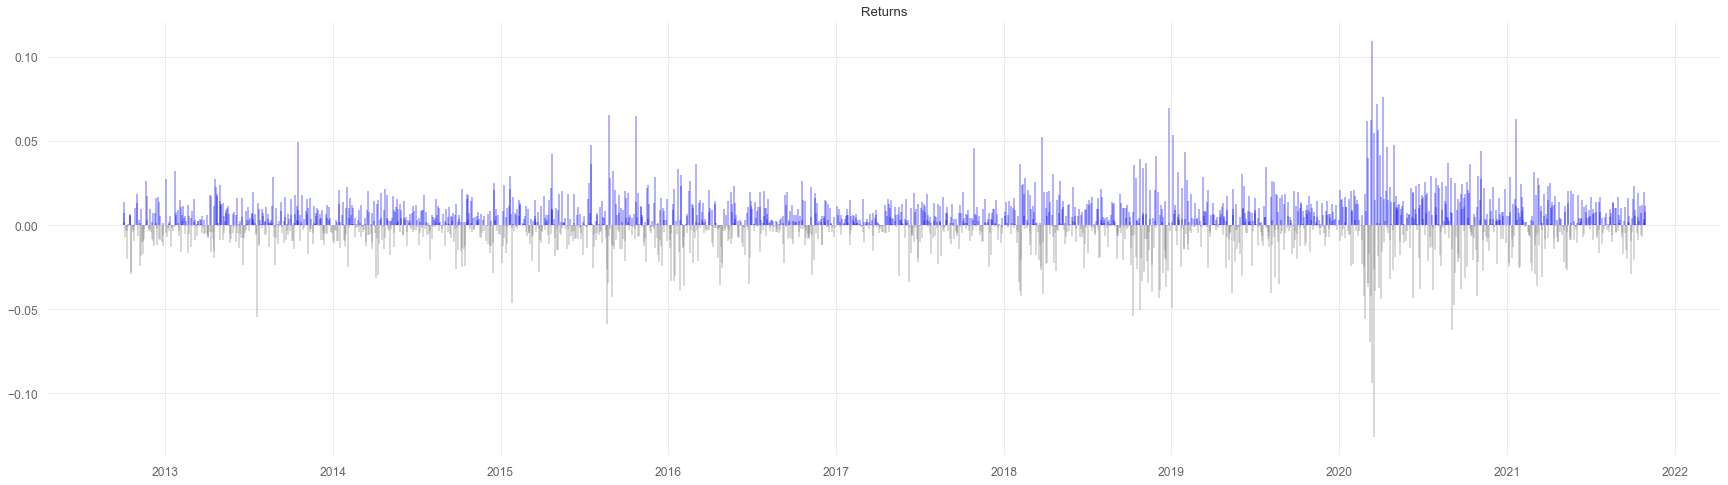

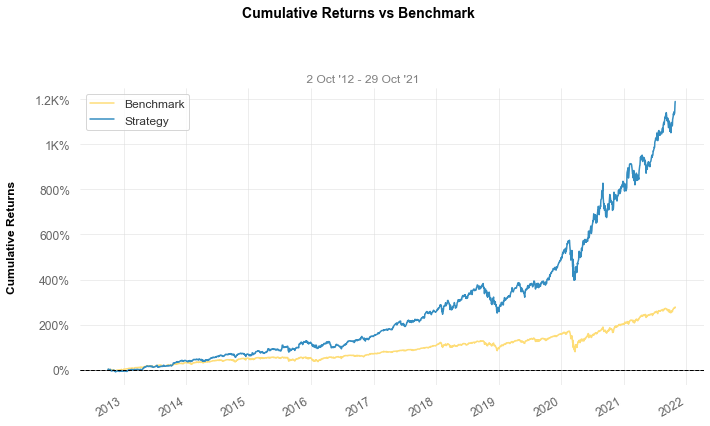

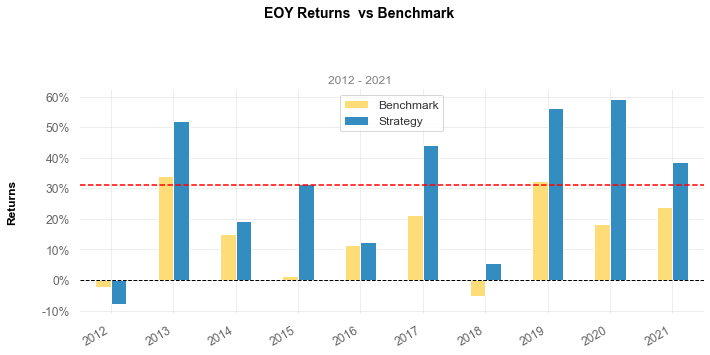

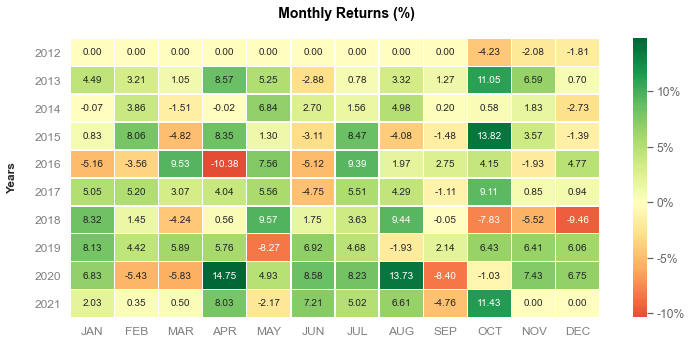

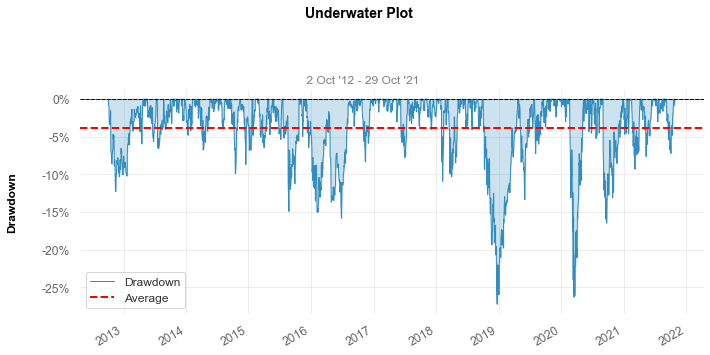

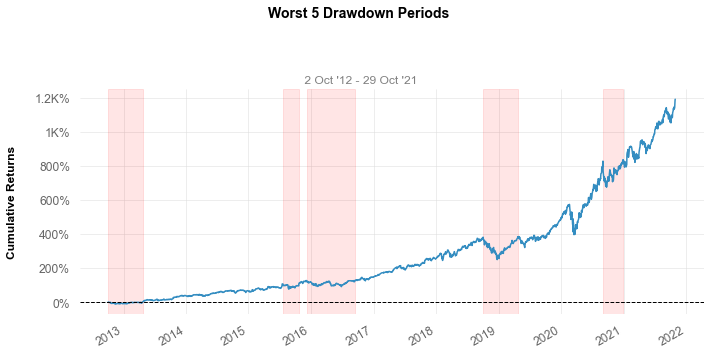

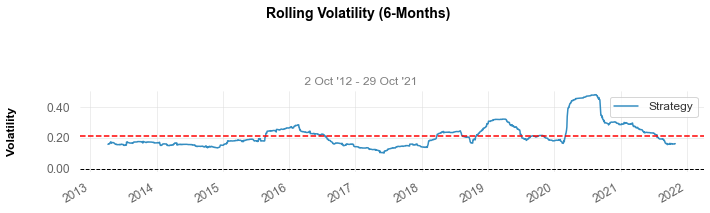

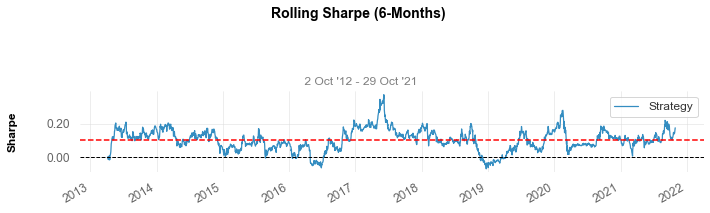

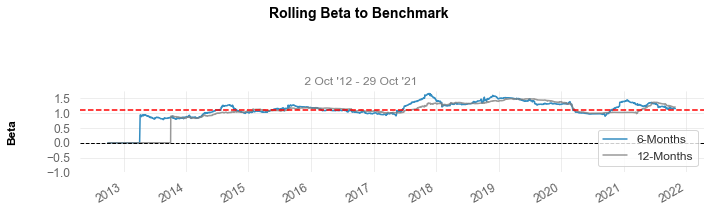

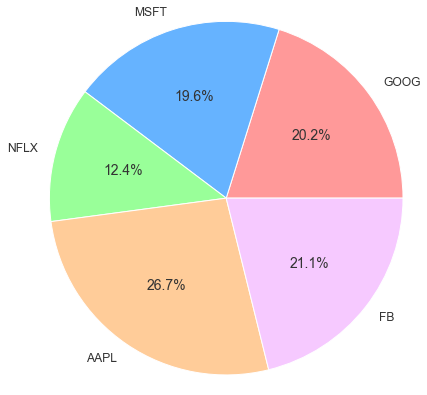

Sharpe_Ratio is : ['1.52', '1.37']


In [16]:
## Mean Variance Method:

portfolio_MEANVAR = Engine(
    start_date = "2012-10-01",
    portfolio = ["GOOG", "MSFT", "NFLX", "AAPL", "FB"],
    optimizer = "HRP",
    rebalance = "1y",
    max_vol = 20
)

empyrial(portfolio_MEANVAR)
sharpe_ratios.append(empyrial.SR)
print("Sharpe_Ratio is :", sharpe_ratios)

Start date: 2012-10-01
End date: 2021-10-30


Backtest
                             
Annual return          37.59%
Cumulative return    1685.66%
Annual volatility     23.35 %
Winning day ratio      57.78%
Sharpe ratio             1.48
Calmar ratio             1.36
Information ratio        0.01
Stability                0.98
Max Drawdown         -27.52 %
Sortino ratio            2.16
Skew                    -0.31
Kurtosis                 6.76
Tail Ratio               0.97
Common sense ratio       1.27
Daily value at risk    -2.0 %
Alpha                    0.18
Beta                     1.12

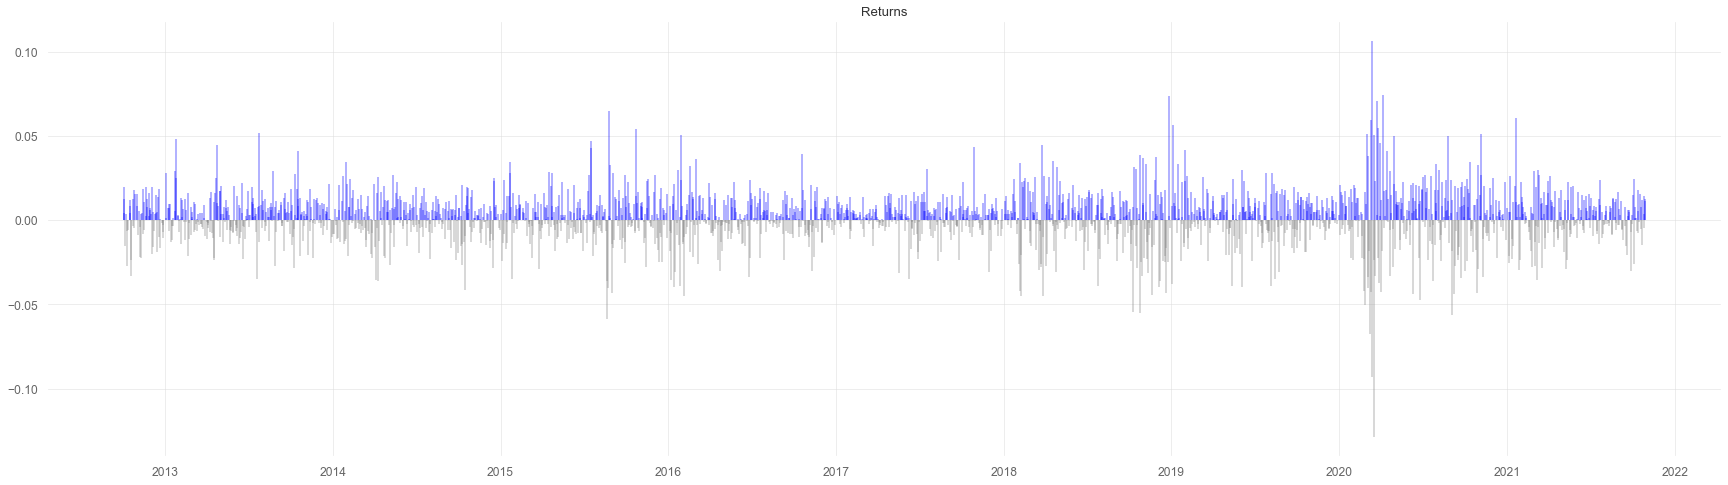

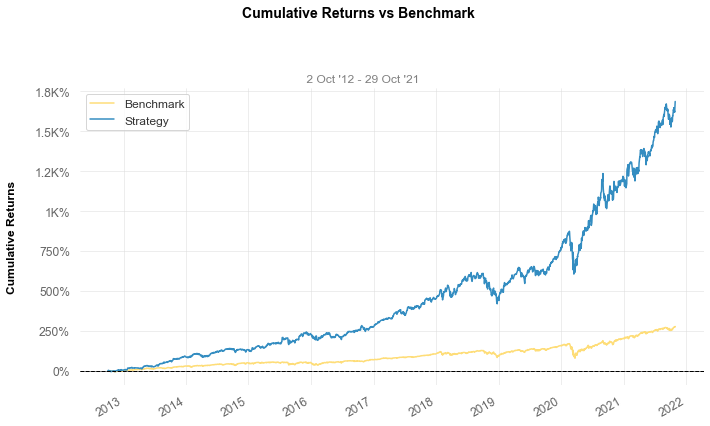

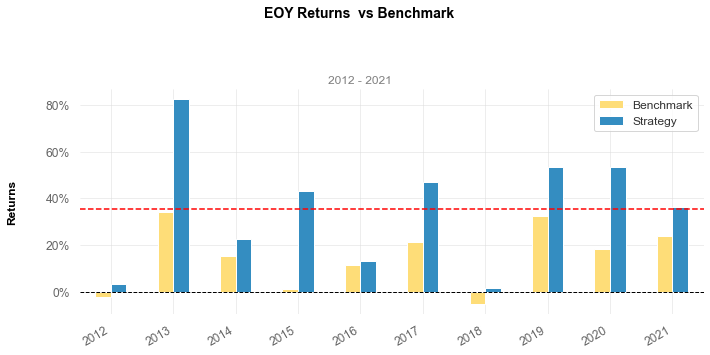

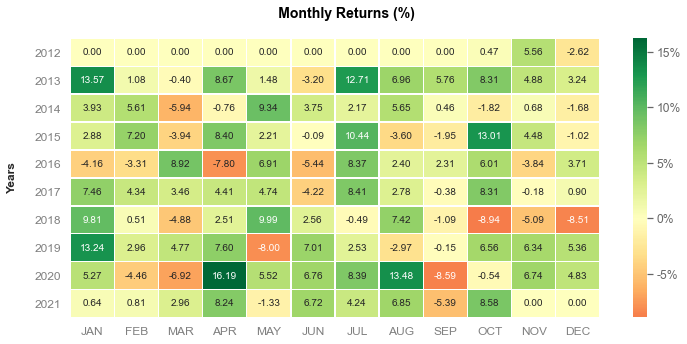

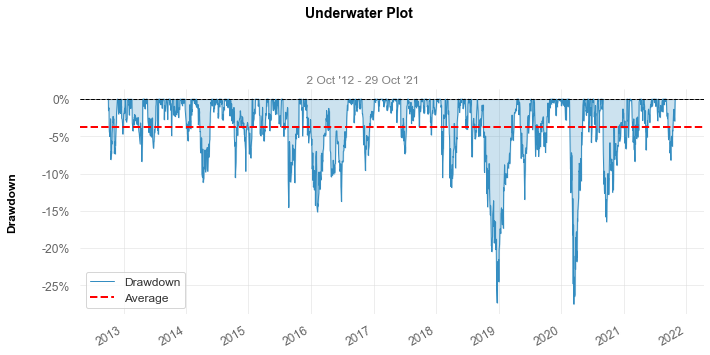

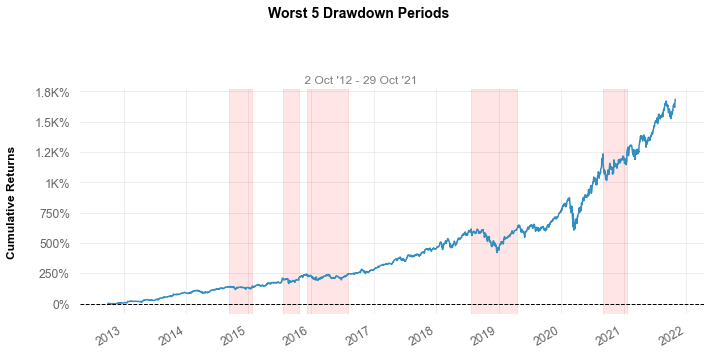

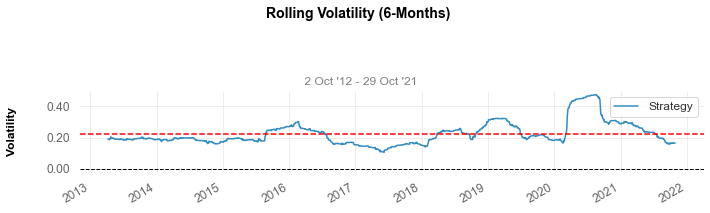

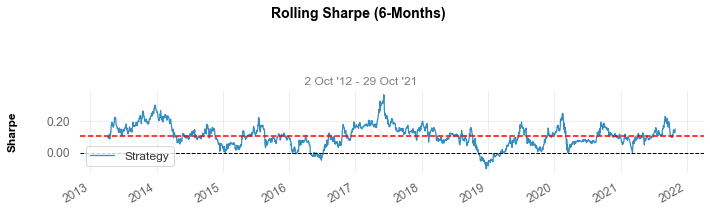

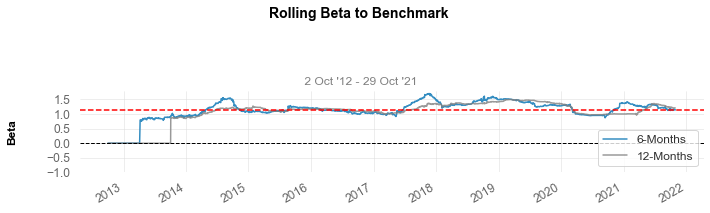

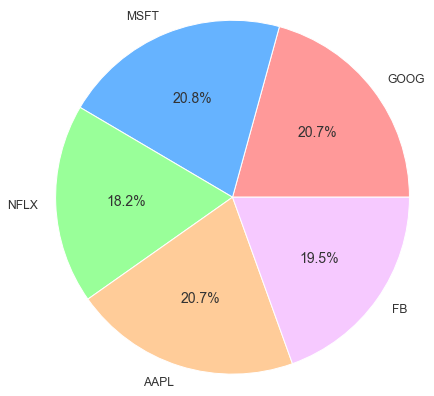

Sharpe_Ratio is : ['1.52', '1.37', '1.48']


In [17]:
## Min Variance Method:

portfolio_MINVAR = Engine(
    start_date = "2012-10-01",
    portfolio = ["GOOG", "MSFT", "NFLX", "AAPL", "FB"],
    optimizer = "MINVAR",
    rebalance = "1y",
)

empyrial(portfolio_MINVAR)
sharpe_ratios.append(empyrial.SR)
print("Sharpe_Ratio is :", sharpe_ratios)

In [18]:
print(sharpe_ratios)

['1.52', '1.37', '1.48']


In [19]:
## Comparisons of these Methods:

labels = ['EF', 'MEANVAR', 'MINVAR']
x = list(range(len(sharpe_ratios)))
#print(sharpe_ratios)

color_discrete_map = {'EF': 'rgb(0,0,0)'}
#fig = px.bar(x=labels, y = [float(_) for _ in sharpe_ratios], 
fig = px.bar(x=labels, y = [float(_) for _ in sharpe_ratios], 
             labels={'x':'Portfolio Optimization Method', 'y':'Sharpe Ratio'},
             color = sharpe_ratios,
            )
fig.update_layout(yaxis_range=[.5,1.9])
fig.show()